## Import Libraries

In [1]:
#Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

#Libraries for data preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

#Libraries for models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

#Library for models evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import cross_val_score

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Load Data

In [70]:
#Load data
loans = pd.read_csv("./data/lending-club-data.csv")
loans.head()

c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (19,47) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1


## Data Preprocessing

### Filtering

Based on the recommendations from NB01, our team will firstly use the same set of features for this task.

In [71]:
features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'installment',               # the monthly payment owed by the borrower if the loan originates
            'payment_inc_ratio'          # borrower's payment to income ratio
           ]
target = ['bad_loans']

X = loans[features]
y = loans[target]

Review the dataset after filtering the features

In [72]:
X.head()

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,int_rate,installment,payment_inc_ratio
0,B,B2,0,11,RENT,27.65,credit_card,36 months,1,1,83.7,0.00,10.65,162.87,8.14350
1,C,C4,1,1,RENT,1.00,car,60 months,1,1,9.4,0.00,15.27,59.83,2.39320
2,C,C5,0,11,RENT,8.72,small_business,36 months,1,1,98.5,0.00,15.96,84.33,8.25955
3,C,C1,0,11,RENT,20.00,other,36 months,0,1,21.0,16.97,13.49,339.31,8.27585
4,A,A4,0,4,RENT,11.20,wedding,36 months,1,1,28.3,0.00,7.90,156.46,5.21533


In [73]:
y.head()

,bad_loans
0,0
1,1
2,0
3,0
4,0


## Exploratory Data Analysis (EDA)

In [74]:
sns.set_theme()

dataset = pd.concat([X, y], axis=1)
dataset.describe()

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,int_rate,installment,payment_inc_ratio,bad_loans
count,122607.000000,122607.000000,122607.000000,122607.000000,122607.000000,122607.000000,122607.000000,122607.000000,122607.000000,122603.000000,122607.000000
mean,0.123672,6.370256,15.496888,0.588115,0.873906,53.716307,0.742344,13.639487,396.623285,7.564725,0.188815
std,0.329208,3.736014,7.497442,0.492177,0.331957,25.723881,5.363268,4.390836,239.475936,4.127291,0.391363
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.420000,15.670000,0.028895,0.000000
25%,0.000000,3.000000,9.880000,0.000000,1.000000,34.800000,0.000000,10.620000,215.985000,4.362575,0.000000
50%,0.000000,6.000000,15.260000,1.000000,1.000000,55.700000,0.000000,13.480000,348.180000,6.965760,0.000000
75%,0.000000,11.000000,20.850000,1.000000,1.000000,74.300000,0.000000,16.290000,521.930000,10.215850,0.000000
max,1.000000,11.000000,39.880000,1.000000,1.000000,150.700000,208.820000,26.060000,1408.130000,54.171000,1.000000


Distribution of target labels

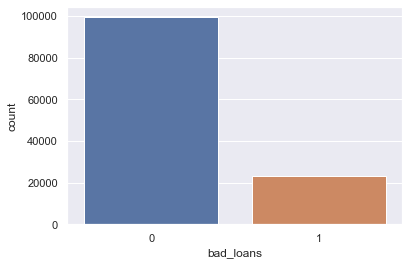

In [76]:
sns.countplot(x='bad_loans', data=dataset);

We can recognize a problem here. The dataset is seriously imbalanced, as the number of samples with "0" label (good loans) are about nearly 4 times more than the samples with "1" label. This suggest us that further processing to balance the dataset is required.

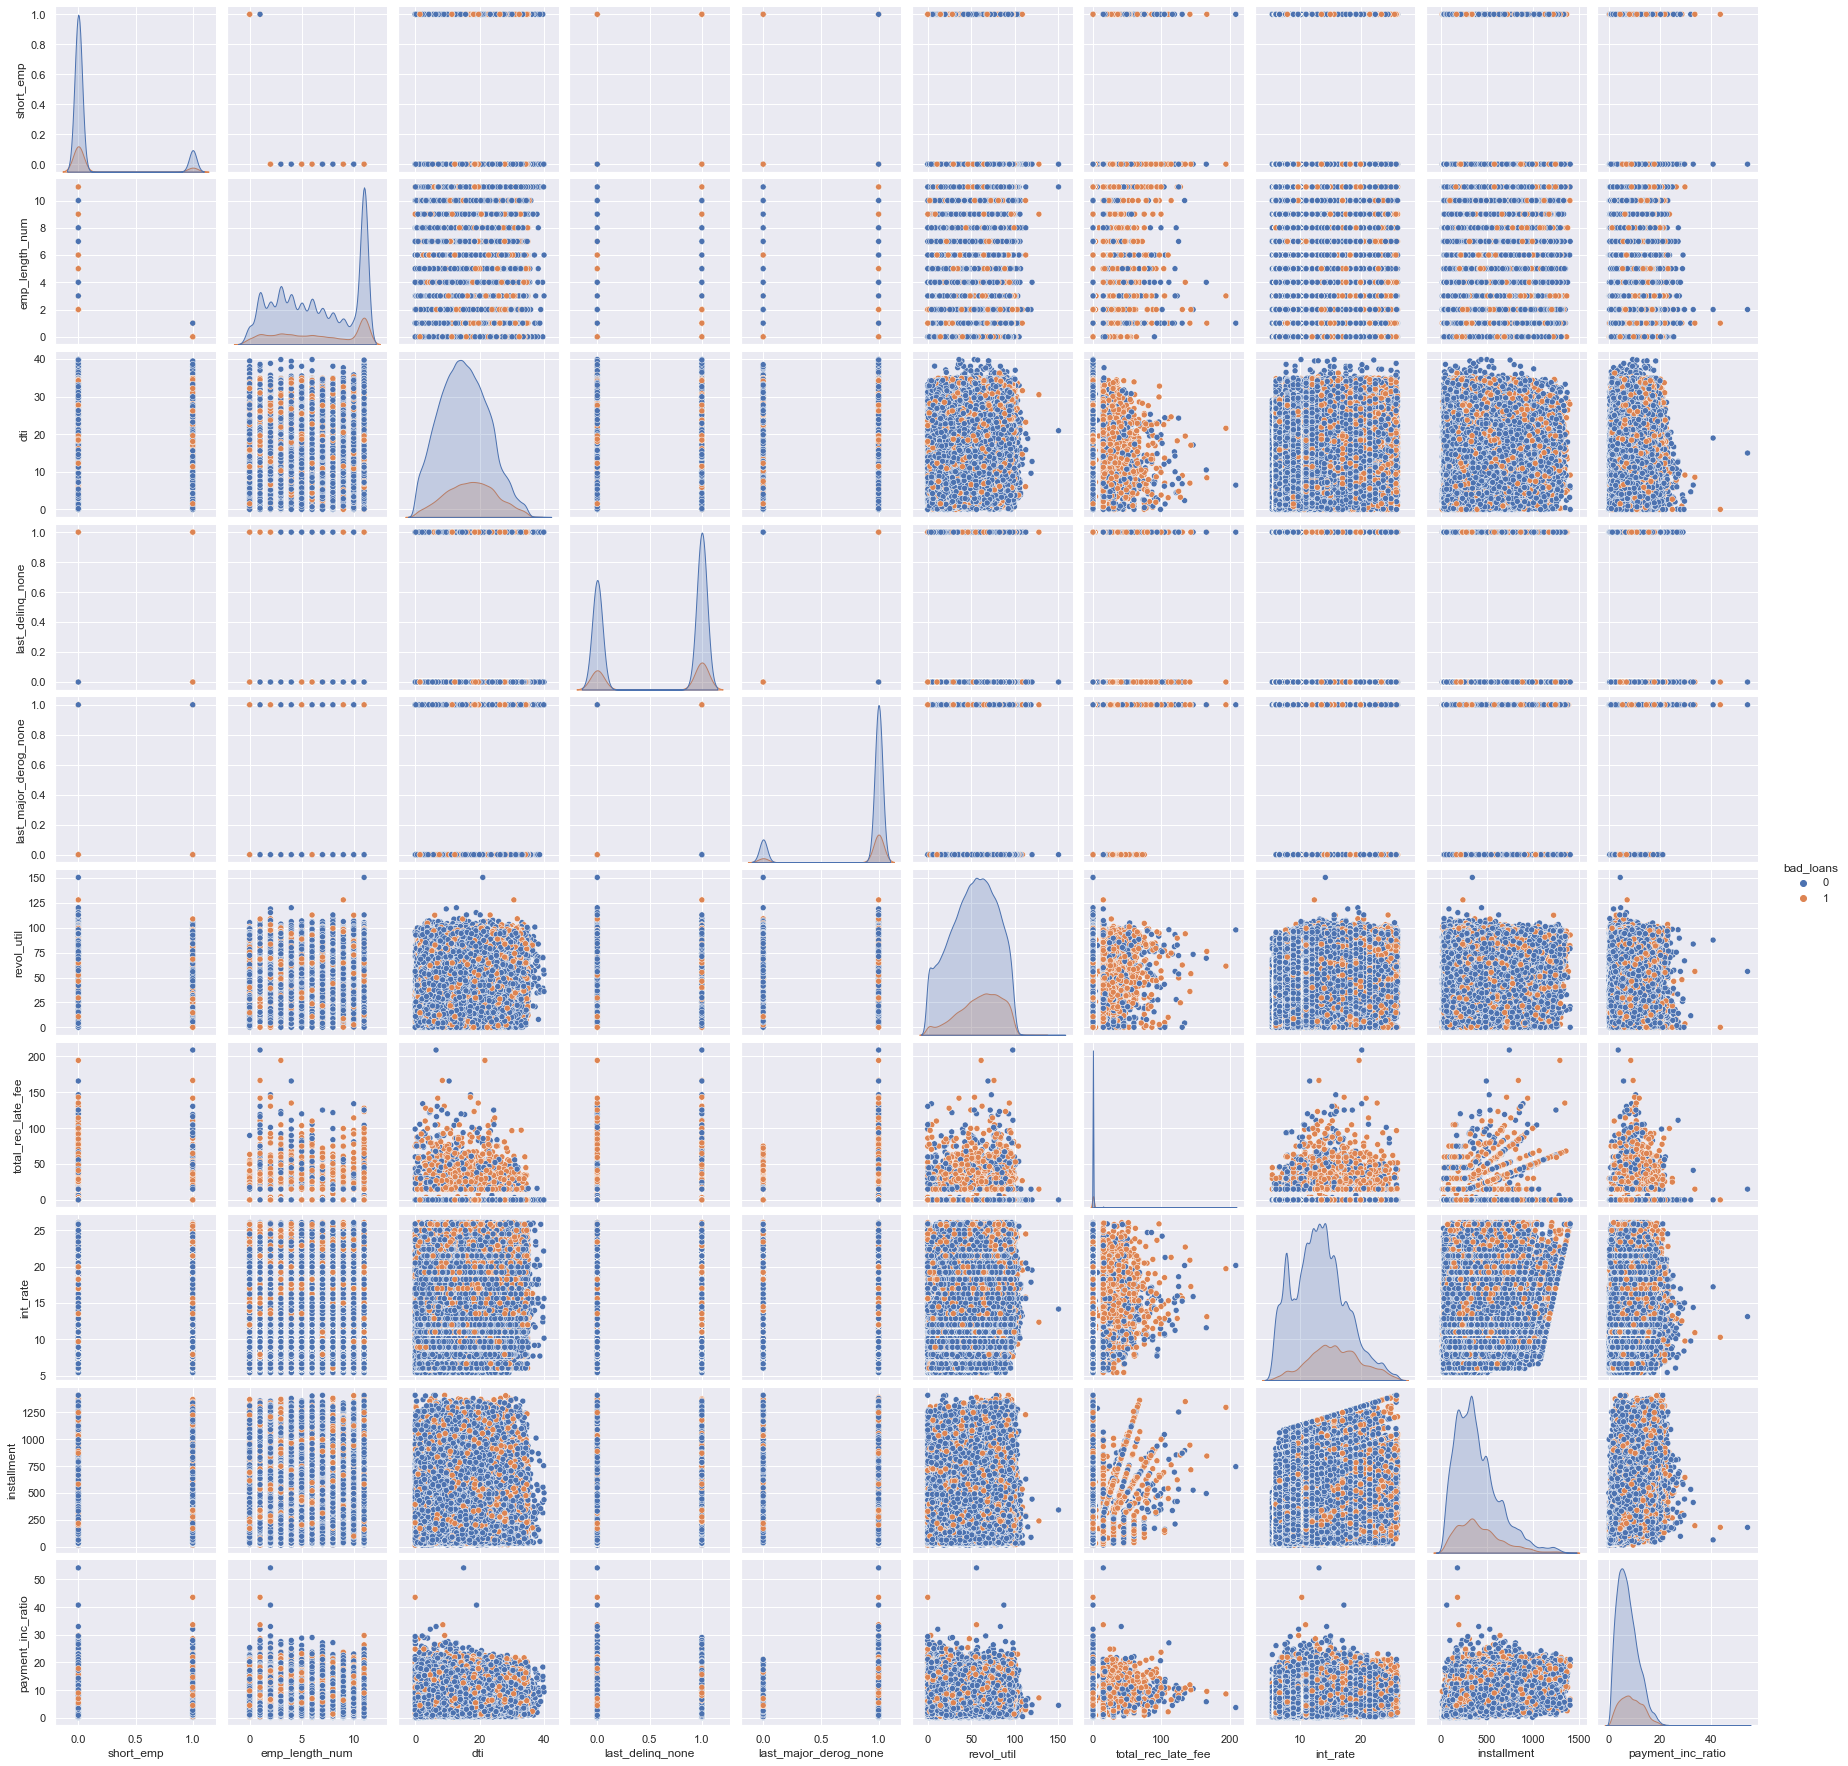

In [77]:
sns.pairplot(dataset, hue='bad_loans');

The pair plot generally shows that some relationships can be figured out. For example, it can be observed that the features       'last_delinq_none' and 'last_major_derog_none' have a correlation where loans with both features holding values 0 tend to be bad_loans (label 0). However, this may not be true because the colors does not clearly illustrate the density. Using a scatterplot with opacity for each point, we can see that the results can be different

<AxesSubplot:xlabel='last_delinq_none', ylabel='last_major_derog_none'>

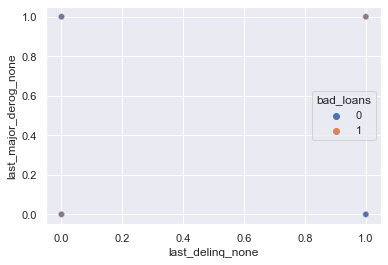

In [78]:
sns.scatterplot(x='last_delinq_none', y='last_major_derog_none', hue='bad_loans', data=dataset, alpha=0.25)

Clearly, good loans and bad loans varied with the values of both features.

For this dataset, because the target labels are 0 and 1, and there exists some categorical features. Observing the relationship between features using chi_score to select the "good" features.

<AxesSubplot:>

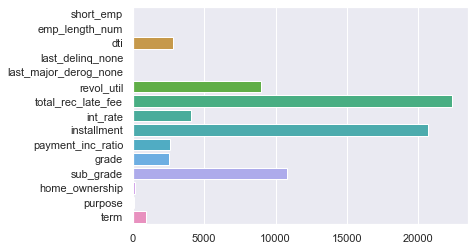

In [80]:
ds = dataset.dropna()
X_clone = ds.drop(["bad_loans"], axis = 1)
y_clone = ds[["bad_loans"]]

X_categorical = X_clone.select_dtypes(include=[object])
categorical_features = X_categorical.columns.tolist()
X_categorical = X_categorical.apply(LabelEncoder().fit_transform)
X_clone.drop(columns=categorical_features, inplace=True)
X_clone = pd.concat([X_clone, X_categorical], axis=1)

chi2_features = SelectKBest(chi2, k="all")
chi2_features.fit_transform(X_clone, y_clone)
chi2_features.scores_

sns.barplot(x=chi2_features.scores_, y=X_clone.columns)

**total_rec_late_fee**, **installment**, **sub_grade** and **revol_util** are some of the features that tend to be dependent with the target labels.

## Data Preprocessing (cont.)

### Resolve Imbalance

In [6]:
def resample(X_data, y_data):
    undersample = RandomUnderSampler(sampling_strategy='majority')
    return undersample.fit_resample(X_data, y_data)

### Train/Test Split

In [7]:
def dataset_split(X_data, y_data):
    return train_test_split(X_data, y_data, test_size=0.2, random_state=35)

In [8]:
X, y = resample(X, y)

ds = pd.concat([X, y], axis = 1)
ds.dropna()
X = ds.drop(["bad_loans"], axis = 1)
y = ds[["bad_loans"]]

In [9]:
X_train_global, X_test_global, y_train_global, y_test_global = dataset_split(X, y)

### Feature Selection

This function selects the best n features from the dataset and return the filtered dataset

In [15]:
def calculateFeatureScores(X_data, y_data, eval_method):
    X_features = X_data.copy()
    X_categorical = X_data.select_dtypes(include=[object])
    categorical_features = X_categorical.columns.tolist()
    
    #Apply label encoder to categorical features
    X_categorical = X_categorical.apply(LabelEncoder().fit_transform)
    
    #Merge with original input data
    X_features.drop(columns=categorical_features, inplace=True)
    X_features = pd.concat([X_features, X_categorical], axis=1)
    
    chi2_features = SelectKBest(eval_method, k="all")
    chi2_features.fit_transform(X_features, y_data)
    return X_features.columns, chi2_features

def getFeatures(X_data, features, scores, n_features):
    scores = np.array(scores)
    indexes = np.argsort(scores)[-n_features:].tolist()[::-1]
    selected_features = [features[i] for i in indexes]
    return X_data[selected_features]

### Feature Scaling

This function performs the normalization for dataset and return the normalized dataset

In [16]:
def normalized(X_data, scaler):
    scaler.fit(X_data)
    return pd.DataFrame(scaler.fit_transform(X_data.values), columns=X_data.columns, index=X_data.index)

### One-Hot Encoding

This function performs one-hot encoding for the dataset

In [17]:
def oneHotEncoding(X_data):
    categorical_features = X_data.select_dtypes(include=[object])
    one_hot_result = pd.DataFrame()
    
    get_features = list(categorical_features.columns)
    for feature in get_features:
        dummies = pd.get_dummies(categorical_features[feature])
        #Concat dummies to the original dataset
        one_hot_result = pd.concat([one_hot_result, dummies], axis=1)

    X_one_hot = X_data.copy()
    X_one_hot.drop(columns=get_features, inplace=True)
    X_one_hot = pd.concat([X_one_hot, one_hot_result], axis = 1)
    return X_one_hot

### Data Preprocessing Implementation

In [18]:
def preprocessing(X_train, y_train, X_test, feature_selection_method):
    features, scores = calculateFeatureScores(X_train, y_train, feature_selection_method)
    
    results = []
    for i in range(11, 16):
        train = getFeatures(X_train, features.tolist(), scores.scores_, i)
        train = oneHotEncoding(train)
        train = normalized(train, MinMaxScaler())
        
        test = getFeatures(X_test, features.tolist(), scores.scores_, i)
        test = oneHotEncoding(test)
        test = normalized(test, MinMaxScaler())
        results.append((i, train, test))
    
    return results

def preprocess_without_select(X):
    dataset = oneHotEncoding(X)
    dataset = normalized(dataset, MinMaxScaler())
    return dataset

### Hyperparameters Tuning

The following function performs the tuning of hyperparameters of the models

In [19]:
def hyperparam_tuning(X_data, y_data, params, model):
    grid = RandomizedSearchCV(
        model, 
        params, 
        verbose = 3, 
        n_jobs = 4, 
        cv = 5, 
        return_train_score = True
    ) 
    grid.fit(X_data, y_data)
    return grid

## Model Training

In [20]:
def execute(model, evaluation_method, X_train, y_train, X_test, y_test, tuning_params=None, is_tuning=False):
    datasets = preprocessing(X_train, y_train, X_test, evaluation_method)
    trains = []
    tests = []
    
    for features, train, test in datasets:
        X_train, X_test = train, test
        
        if is_tuning:
            result = hyperparam_tuning(X_train, y_train, tuning_params, model)
            model = result.best_estimator_
            best_params = result.best_params_
        else:
            best_params = tuning_params
    
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)
        p_train, r_train, f1_train, _ = precision_recall_fscore_support(y_train, y_train_pred, average='weighted')
        p_test, r_test, f1_test, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
        
        trains.append({
            "features": features,
            "accuracy": accuracy_score(y_train, y_train_pred),
            "classification_report": classification_report(y_train, y_train_pred),
            "confusion_matrix": confusion_matrix(y_train, y_train_pred),
            "precision": p_train,
            "recall": r_train,
            "f1": f1_train,
            "params": best_params
        })
        tests.append({
            "features": features,
            "accuracy": accuracy_score(y_test, y_pred),
            "classification_report": classification_report(y_test, y_pred),
            "confusion_matrix": confusion_matrix(y_test, y_pred),
            "precision": p_test,
            "recall": r_test,
            "f1": f1_test,
            "params": best_params
        })

    return trains, tests

In [21]:
# Global dataset
X_train_global_normed = preprocess_without_select(X_train_global)
X_test_global_normed = preprocess_without_select(X_test_global)

### Model 1: Decision Tree

In [22]:
def decisionTree():
    #Find the set of best parameters
    params = {
        'max_depth': [2, 3, 5, 10, 20],
        'min_samples_leaf': [5, 10, 20, 50, 100],
        'criterion': ["gini", "entropy"]
    }
    
    methods = [chi2, mutual_info_classif]
    methodNames = ["chi2", "mutual_info"]
    
    result = hyperparam_tuning(X_train_global_normed, y_train_global, params, DecisionTreeClassifier())
    return_results = []
    
    for i, method in enumerate(methods):
        trains, tests = execute(result.best_estimator_, method, X_train_global, y_train_global, X_test_global, y_test_global,
                                params, True)
        return_results.append({
            "method": methodNames[i],
            "train": trains,
            "test": tests
        })
    
    return return_results

### Model 2: KNN

In [23]:
def kNearestNeighbors():
    #Find the set of best parameters
    params = {
        'n_neighbors' : range(5, 16, 2),
        'weights' : ['uniform','distance'],
        'metric' : ['euclidean', 'manhattan', 'minkowski']
    }
    
    methods = [chi2, mutual_info_classif]
    methodNames = ["chi2", "mutual_info"]
    
    result = hyperparam_tuning(X_train_global_normed, y_train_global, params, KNeighborsClassifier())
    return_results = []
    
    for i, method in enumerate(methods):
        trains, tests = execute(result.best_estimator_, method, X_train_global, y_train_global, X_test_global, y_test_global,
                               result.best_params_, False)
        return_results.append({
            "method": methodNames[i],
            "train": trains,
            "test": tests
        })
    
    return return_results

### Model 3: Random Forest

In [24]:
def randomForest():
    #Find the set of best parameters
    params = {
        'n_estimators': range(10, 110, 10),
        'max_features' : ['auto', 'sqrt'],
        'min_samples_split' : [2, 5],
        'min_samples_leaf' : [1, 2],
    }
    
    methods = [chi2, mutual_info_classif]
    methodNames = ["chi2", "mutual_info"]
    
    result = hyperparam_tuning(X_train_global_normed, y_train_global, params, RandomForestClassifier())
    return_results = []
    
    for i, method in enumerate(methods):
        trains, tests = execute(result.best_estimator_, method, X_train_global, y_train_global, X_test_global, y_test_global,
                                params, True)
        return_results.append({
            "method": methodNames[i],
            "train": trains,
            "test": tests
        })
    
    return return_results

### Model 4: Logistic Regression

In [25]:
def logisticRegression():
    #Find the set of best parameters
    params = {
        'solver': ['newton-cg', 'lbfgs', 'liblinear'],
        'penalty' : ['l2'],
        'C' : [100, 10, 1.0, 0.1, 0.01],
    }
    
    methods = [chi2, mutual_info_classif]
    methodNames = ["chi2", "mutual_info"]
    
    result = hyperparam_tuning(X_train_global_normed, y_train_global, params, LogisticRegression())
    return_results = []
    
    for i, method in enumerate(methods):
        trains, tests = execute(result.best_estimator_, method, X_train_global, y_train_global, X_test_global, y_test_global,
                                params, True)
        return_results.append({
            "method": methodNames[i],
            "train": trains,
            "test": tests
        })
    
    return return_results

### Model 5: Bernoulli Naïve Bayes

In [26]:
def bernoulliNaiveBayes():
    #Find the set of best parameters
    params = {
        'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]
    }
    
    methods = [chi2, mutual_info_classif]
    methodNames = ["chi2", "mutual_info"]
    
    result = hyperparam_tuning(X_train_global_normed, y_train_global, params, BernoulliNB())
    return_results = []
    
    for i, method in enumerate(methods):
        trains, tests = execute(result.best_estimator_, method, X_train_global, y_train_global, X_test_global, y_test_global,
                                params, True)
        return_results.append({
            "method": methodNames[i],
            "train": trains,
            "test": tests
        })
    
    return return_results

### Model 6: Support Vector Machine

In [27]:
def supportVectorMachine():
    #Find the set of best parameters
    params = {
        'kernel': ['poly', 'rbf', 'sigmoid'],
        'C': [50, 10, 1.0, 0.1, 0.01],
        'gamma': ['scale']
    }
    
    methods = [chi2, mutual_info_classif]
    methodNames = ["chi2", "mutual_info"]
    
    result = hyperparam_tuning(X_train_global_normed, y_train_global, params, SVC())
    return_results = []
    
    for i, method in enumerate(methods):
        trains, tests = execute(result.best_estimator_, method, X_train_global, y_train_global, X_test_global, y_test_global,
                               result.best_params_, False)
        return_results.append({
            "method": methodNames[i],
            "train": trains,
            "test": tests
        })
    
    return return_results

### Model 7: Deep Neural Network

In [37]:
def deepNeuralNetwork():
    return_results = []
    
    methods = [chi2, mutual_info_classif]
    methodNames = ["chi2", "mutual_info"]
    
    for i, method in enumerate(methods):
        features, scores = calculateFeatureScores(X_train_global, y_train_global, method)
    
        trains = []
        tests = []
        
        for j in range(11, 16):
            X_train = getFeatures(X_train_global, features.tolist(), scores.scores_, i)
            X_train = oneHotEncoding(X_train)
            X_train = normalized(X_train, MinMaxScaler())

            X_test = getFeatures(X_test_global, features.tolist(), scores.scores_, i)
            X_test = oneHotEncoding(X_test)
            X_test = normalized(X_test, MinMaxScaler())
           
            model = Sequential()
            model.add(Dense(64, activation='relu', input_dim=len(X_train.columns)))
            model.add(Dense(32, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            early_stopping = EarlyStopping(patience=5)
            
            model.summary()
            
            model.fit(X_train, y_train_global, validation_data=(X_test, y_test_global), 
                      epochs=40, batch_size=100, callbacks=[early_stopping])

            train_result = model.evaluate(X_train, y_train_global)
            test_result = model.evaluate(X_test, y_test_global)
            train_output = model.predict(X_train)
            test_output = model.predict(X_test)
            y_train_pred = np.where(train_output > 0.5, 1, 0).reshape(1, len(X_train_global))[0]
            y_test_pred = np.where(test_output > 0.5, 1, 0).reshape(1, len(X_test_global))[0]
            p_train, r_train, f1_train, _ = precision_recall_fscore_support(y_train_global, y_train_pred, average='weighted')
            p_test, r_test, f1_test, _ = precision_recall_fscore_support(y_test_global, y_test_pred, average='weighted')
            
            trains.append({
                "features": j,
                "accuracy": train_result[1],
                "classification_report": classification_report(y_train_global, y_train_pred),
                "confusion_matrix": confusion_matrix(y_train_global, y_train_pred),
                "precision": p_train,
                "recall": r_train,
                "f1": f1_train,
                "params": {}
            })
            tests.append({
                "features": j,
                "accuracy": test_result[1],
                "classification_report": classification_report(y_test_global, y_test_pred),
                "confusion_matrix": confusion_matrix(y_test_global, y_test_pred),
                "precision": p_test,
                "recall": r_test,
                "f1": f1_test,
                "params": {}
            })
            
        return_results.append({
            "method": methodNames[i],
            "train": trains,
            "test": tests
        })
    
    return return_results

## Main Implementation

In [29]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

def create_json(fileName, objList):
    with open(fileName, "w") as file:
        json.dump(objList, file, cls=NumpyEncoder)

In [30]:
dt = decisionTree()
create_json("decisionTree.txt", dt)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [31]:
rf = randomForest()
create_json("randomForest.txt", rf)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
<ipython-input-20-a73fc75ea1b9>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
<ipython-input-20-a73fc75ea1b9>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
<ipython-input-20-a73fc75ea1b9>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
<ipython-input-20-a73fc75ea1b9>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
<ipython-input-20-a73fc75ea1b9>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
<ipython-input-20-a73fc75ea1b9>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
<ipython-input-20-a73fc75ea1b9>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
<ipython-input-20-a73fc75ea1b9>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
<ipython-input-20-a73fc75ea1b9>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
<ipython-input-20-a73fc75ea1b9>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


In [32]:
lr = logisticRegression()
create_json("logisticRegression.txt", lr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [33]:
bnb = bernoulliNaiveBayes()
create_json("bernoulliNaiveBayes.txt", bnb)

c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:292: UserWa

Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [38]:
dnn = deepNeuralNetwork()
create_json("deepNeuralNetwork.txt", dnn)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                4544      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 6,657
Trainable params: 6,657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
371/371 [==============================] - 1s 2ms/step - loss: 0.6587 - accuracy: 0.6037 - val_loss: 0.6337 - val_accuracy: 0.6384
Epoch 2/40
371/371 [==============================] - 0s 936us/step - loss: 0.6317 - accuracy: 0.6396 - val_loss: 0.6280 - val_accuracy: 0.6446
Epoch 3/40
371/371 [==============================] - 0s 918us/step - loss: 0.6232 - accuracy: 0

Epoch 14/40
371/371 [==============================] - 0s 977us/step - loss: 0.6012 - accuracy: 0.6751 - val_loss: 0.6227 - val_accuracy: 0.6531
Epoch 15/40
290/290 [==============================] - 0s 532us/step - loss: 0.6238 - accuracy: 0.6519
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                4544      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 6,657
Trainable params: 6,657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
371/371 [==============================] - 1s 2ms/step - loss: 0.6631 - accuracy: 0.5913 - val_loss: 0.6341 - val_accuracy:

c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
371/371 [==============================] - 1s 1ms/step - loss: 0.6761 - accuracy: 0.5790 - val_loss: 0.6493 - val_accuracy: 0.6183
Epoch 2/40
371/371 [==============================] - 0s 890us/step - loss: 0.6518 - accuracy: 0.6165 - val_loss: 0.6488 - val_accuracy: 0.6193
Epoch 3/40
371/371 [==============================] - 0s 809us/step - loss: 0.6491 - accuracy: 0

371/371 [==============================] - 1s 1ms/step - loss: 0.6774 - accuracy: 0.5872 - val_loss: 0.6488 - val_accuracy: 0.6183
Epoch 2/40
371/371 [==============================] - 0s 892us/step - loss: 0.6517 - accuracy: 0.6136 - val_loss: 0.6482 - val_accuracy: 0.6175
Epoch 3/40
371/371 [==============================] - 0s 809us/step - loss: 0.6509 - accuracy: 0.6154 - val_loss: 0.6481 - val_accuracy: 0.6175
Epoch 4/40
371/371 [==============================] - 0s 848us/step - loss: 0.6523 - accuracy: 0.6157 - val_loss: 0.6482 - val_accuracy: 0.6185
Epoch 5/40
371/371 [==============================] - 0s 848us/step - loss: 0.6498 - accuracy: 0.6167 - val_loss: 0.6477 - val_accuracy: 0.6201
Epoch 6/40
371/371 [==============================] - 0s 812us/step - loss: 0.6507 - accuracy: 0.6149 - val_loss: 0.6478 - val_accuracy: 0.6177
Epoch 7/40
371/371 [==============================] - 0s 806us/step - loss: 0.6494 - accuracy: 0.6165 - val_loss: 0.6478 - val_accuracy: 0.6177
Epoch

Epoch 5/40
371/371 [==============================] - 0s 809us/step - loss: 0.6503 - accuracy: 0.6178 - val_loss: 0.6508 - val_accuracy: 0.6121
Epoch 6/40
371/371 [==============================] - 0s 806us/step - loss: 0.6526 - accuracy: 0.6164 - val_loss: 0.6476 - val_accuracy: 0.6187
Epoch 7/40
371/371 [==============================] - 0s 848us/step - loss: 0.6500 - accuracy: 0.6157 - val_loss: 0.6478 - val_accuracy: 0.6175
Epoch 8/40
371/371 [==============================] - 0s 879us/step - loss: 0.6508 - accuracy: 0.6180 - val_loss: 0.6476 - val_accuracy: 0.6183
Epoch 9/40
371/371 [==============================] - 0s 851us/step - loss: 0.6492 - accuracy: 0.6207 - val_loss: 0.6477 - val_accuracy: 0.6173
Epoch 10/40
371/371 [==============================] - 0s 847us/step - loss: 0.6509 - accuracy: 0.6173 - val_loss: 0.6474 - val_accuracy: 0.6187
Epoch 11/40
371/371 [==============================] - 0s 869us/step - loss: 0.6486 - accuracy: 0.6169 - val_loss: 0.6475 - val_accurac

In [39]:
knn = kNearestNeighbors()
create_json("kNearestNeighbors.txt", knn)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\neighbors\_classification.py:198: Data

In [40]:
svm = supportVectorMachine()
create_json("supportVectorMachine.txt", svm)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversio

# Evaluation

In [41]:
results = [dt, rf, lr, bnb, dnn, knn, svm]
resultLabels = [
    "Decision Tree",
    "Random Forest",
    "Logistic Regression",
    "Bernoulli Naïve Bayes",
    "Deep Neural Network",
    "K-Nearest Neigbors",
    "Support Vector Machine",
]

## Select the best accuracy and best weighted F1-score for the classifiers

In [42]:
showing = []

for i, model in enumerate(results):
    best_accuracy = 0
    best_features = 0
    best_method = ''
    best_f1 = 0
    best_f1_features = 0
    best_f1_method = ''
    for method in model:
        for trial in method["test"]:
            if trial["accuracy"] > best_accuracy:
                best_accuracy = trial["accuracy"]
                best_features = trial["features"]
                best_method = method["method"]
            if trial["f1"] > best_f1:
                best_f1 = trial["f1"]
                best_f1_features = trial["features"]
                best_f1_method = method["method"]
    showing.append({
        'model': resultLabels[i],
        'result': (best_accuracy, best_features, best_method),
        'f1': (best_f1, best_f1_features, best_f1_method)
    })
    
showing

[{'model': 'Decision Tree',
  'result': (0.6439524838012959, 13, 'mutual_info'),
  'f1': (0.6429917364401716, 13, 'mutual_info')},
 {'model': 'Random Forest',
  'result': (0.6561555075593952, 14, 'mutual_info'),
  'f1': (0.655502320086334, 14, 'mutual_info')},
 {'model': 'Logistic Regression',
  'result': (0.6592872570194385, 15, 'mutual_info'),
  'f1': (0.6573026777304659, 15, 'mutual_info')},
 {'model': 'Bernoulli Naïve Bayes',
  'result': (0.6267818574514039, 13, 'chi2'),
  'f1': (0.6267089402180678, 13, 'chi2')},
 {'model': 'Deep Neural Network',
  'result': (0.6593952775001526, 14, 'chi2'),
  'f1': (0.6593806293211509, 14, 'chi2')},
 {'model': 'K-Nearest Neigbors',
  'result': (0.6145788336933046, 11, 'mutual_info'),
  'f1': (0.6142753881733648, 12, 'mutual_info')},
 {'model': 'Support Vector Machine',
  'result': (0.6442764578833693, 11, 'chi2'),
  'f1': (0.6431966205803091, 11, 'chi2')}]

## Comparison using some charts and graphs

### Accuracies of classifiers

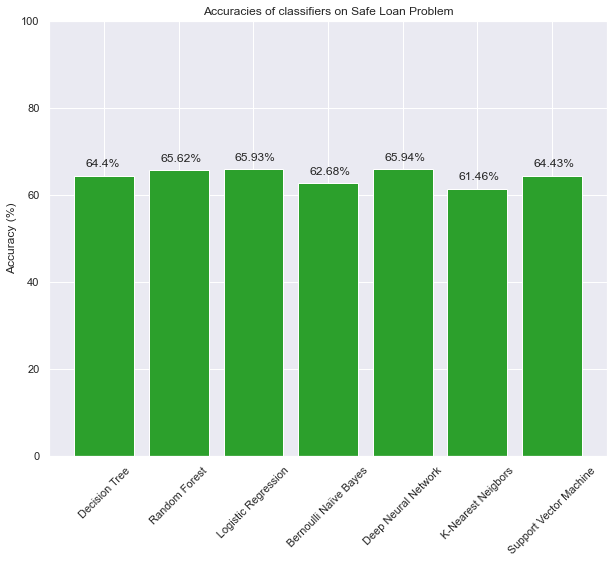

In [43]:
accuracies = [model["result"][0] * 100 for model in showing]

fig, ax = plt.subplots(figsize=(10, 8))
plt.bar(resultLabels, accuracies, color=["tab:green"])
plt.xticks(resultLabels, rotation='45')
plt.ylim(0, 100)
plt.title("Accuracies of classifiers on Safe Loan Problem")
ax.set_ylabel('Accuracy (%)')
for i, accuracy in enumerate(accuracies):
    ax.annotate(str(round(accuracy, 2)) + "%", (i - 0.25, accuracy + 2))
plt.savefig('accuracy.png', dpi=300, bbox_inches = "tight")
plt.show()

### F1-score of classifiers

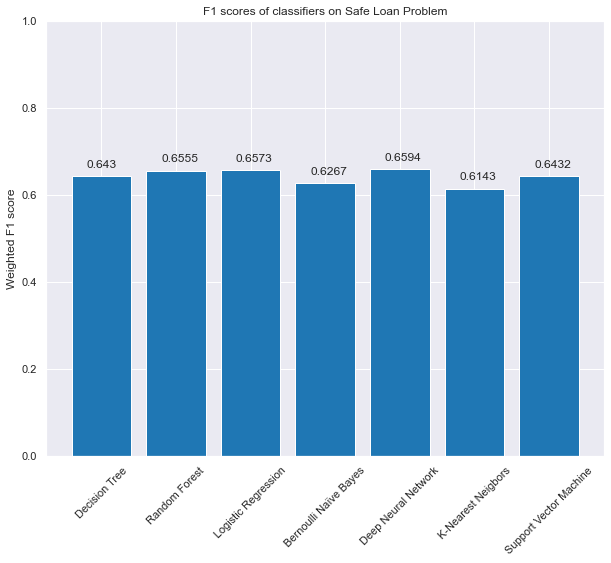

In [44]:
f1_scores = [model["f1"][0] for model in showing]

fig, ax = plt.subplots(figsize=(10, 8))
plt.bar(resultLabels, f1_scores, color=["tab:blue"])
plt.xticks(resultLabels, rotation='45')
plt.ylim(0, 1)
plt.title("F1 scores of classifiers on Safe Loan Problem")
ax.set_ylabel('Weighted F1 score')
for i, f1 in enumerate(f1_scores):
    ax.annotate(str(round(f1, 4)), (i - 0.2, f1 + 0.02))
plt.savefig('f1.png', dpi=300, bbox_inches = "tight")
plt.show()

### Performance of each classifier for different choice of number of features used

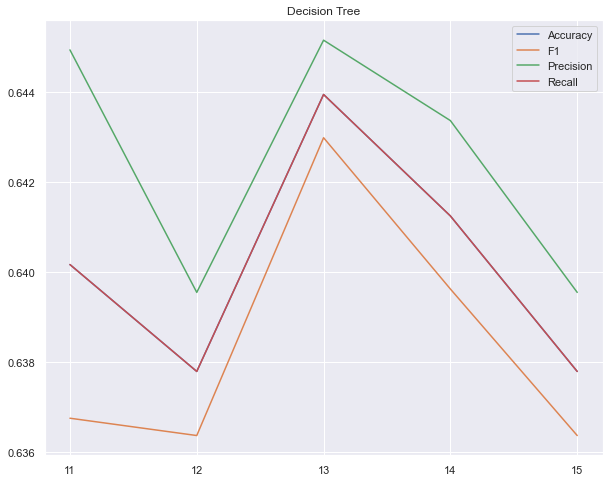

In [45]:
single = []

for i, model in enumerate(results):
    subres = []
    subres2 = []
    subres3 = []
    subres4 = []
    subres5 = []
    subres6 = []
    for j in range(len(method["test"])):
        better_accuracy = 0
        better_accuracy_model = None
        better_f1 = 0
        better_f1_model = None
        better_precision = 0
        better_recall = 0
        for method in model:
            if method["test"][j]["accuracy"] > better_accuracy:
                better_accuracy = method["test"][j]["accuracy"]
                better_accuracy_model = method["test"][j]["params"]
            if method["test"][j]["f1"] > better_f1:
                better_f1 = method["test"][j]["f1"]
                better_f1_model = method["test"][j]["params"]
            if method["test"][j]["precision"] > better_precision:
                better_precision = method["test"][j]["precision"]
            if method["test"][j]["recall"] > better_recall:
                better_recall = method["test"][j]["recall"]
        subres.append(better_accuracy)
        subres2.append(better_f1)
        subres3.append(better_precision)
        subres4.append(better_recall)
        subres5.append(better_accuracy_model)
        subres6.append(better_f1_model)
    single.append({
        "model": resultLabels[i],
        "accuracy": subres,
        "f1": subres2,
        "precision": subres3,
        "recall": subres4,
        "accuracy_model": subres5,
        "f1_model": subres6
    })
    
labels = range(11, 16)
labels = [str(i) for i in labels]

fig, ax = plt.subplots(figsize=(10, 8))

plt.plot(labels, single[0]["accuracy"], label="Accuracy")
plt.plot(labels, single[0]["f1"], label="F1")
plt.plot(labels, single[0]["precision"], label="Precision")
plt.plot(labels, single[0]["recall"], label="Recall")
plt.title(single[0]["model"])
plt.legend()
plt.show()

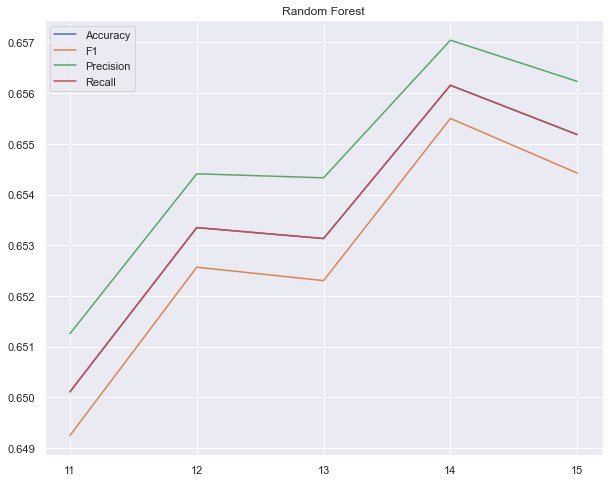

In [46]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(labels, single[1]["accuracy"], label="Accuracy")
plt.plot(labels, single[1]["f1"], label="F1")
plt.plot(labels, single[1]["precision"], label="Precision")
plt.plot(labels, single[1]["recall"], label="Recall")
plt.title(single[1]["model"])
plt.legend()
plt.show()

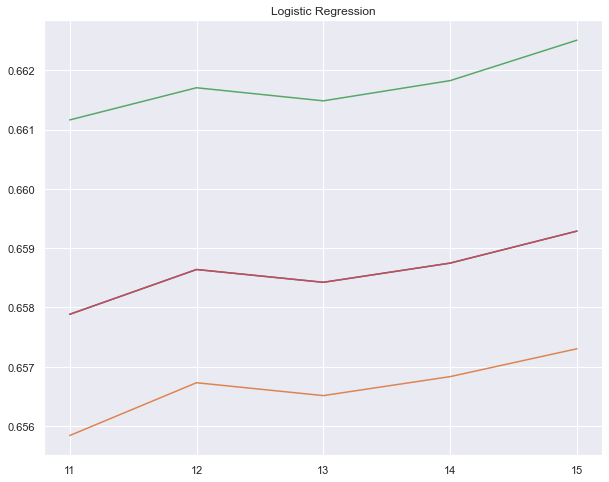

In [47]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(labels, single[2]["accuracy"])
plt.plot(labels, single[2]["f1"])
plt.plot(labels, single[2]["precision"])
plt.plot(labels, single[2]["recall"])
plt.title(single[2]["model"])
plt.show()

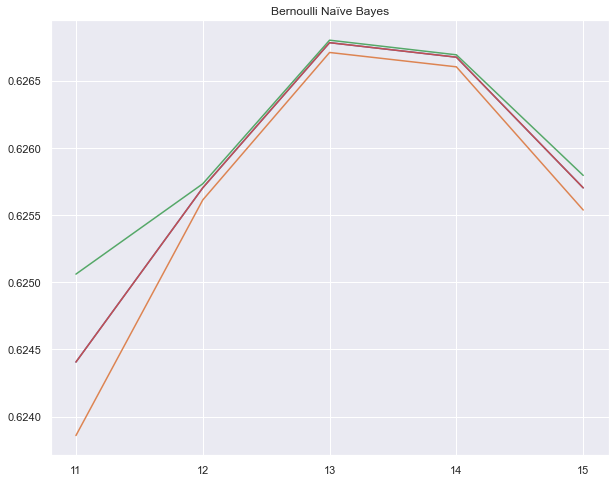

In [48]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(labels, single[3]["accuracy"])
plt.plot(labels, single[3]["f1"])
plt.plot(labels, single[3]["precision"])
plt.plot(labels, single[3]["recall"])
plt.title(single[3]["model"])
plt.show()

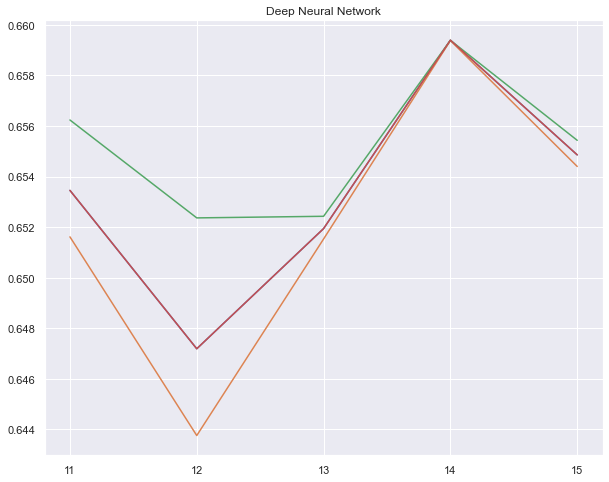

In [49]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(labels, single[4]["accuracy"])
plt.plot(labels, single[4]["f1"])
plt.plot(labels, single[4]["precision"])
plt.plot(labels, single[4]["recall"])
plt.title(single[4]["model"])
plt.show()

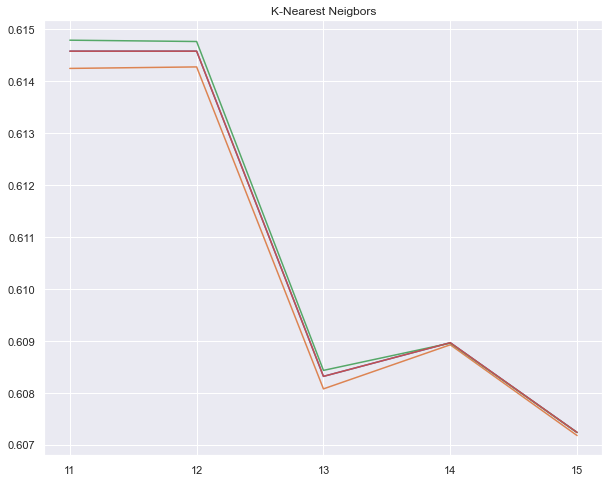

In [50]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(labels, single[5]["accuracy"])
plt.plot(labels, single[5]["f1"])
plt.plot(labels, single[5]["precision"])
plt.plot(labels, single[5]["recall"])
plt.title(single[5]["model"])
plt.show()

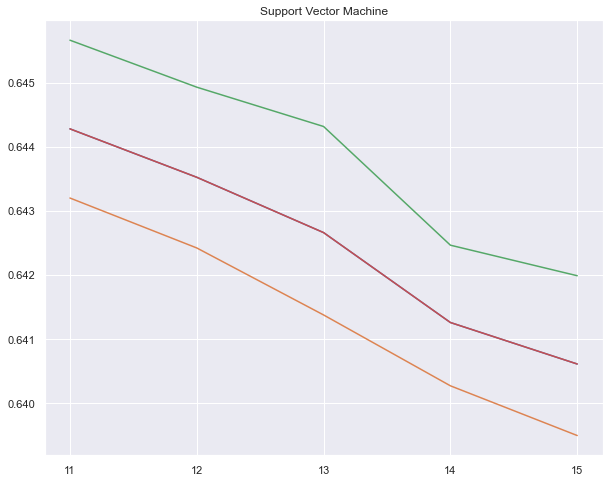

In [51]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(labels, single[6]["accuracy"])
plt.plot(labels, single[6]["f1"])
plt.plot(labels, single[6]["precision"])
plt.plot(labels, single[6]["recall"])
plt.title(single[6]["model"])
plt.show()

### Summary dataframe of the training and evaluation result

In [67]:
classifiers = []
for resultLabel in resultLabels:
    for i in range(5):
        classifiers.append(resultLabel)

arrays = [
    np.array(classifiers),
    np.array([str(i) + " features" for i in range(11, 16)] * 7),
]

values = [value["accuracy"] for value in single]
values = np.array(values).reshape(35, 1)

values_1 = [value["f1"] for value in single]
values_1 = np.array(values_1).reshape(35, 1)

values_2 = [value["accuracy_model"] for value in single]
values_2 = np.array(values_2).reshape(35, 1)

values = np.concatenate((values_2, values, values_1), axis=1)

In [68]:
def highlight_max(values):
    returnArray = []
    for i in range(7):
        subset = values[i * 5 : (i + 1) * 5]
        if isinstance(subset[0], dict):
            return [""] * 35
        pos = np.argmax(subset)
        for j in range(5):
            if j == pos:
                returnArray.append("background: lightgreen")
            else:
                returnArray.append("")
    return returnArray
 
df = pd.DataFrame(values, index=arrays, columns=["Model Params", "Accuracy", "Weighted F1"])
df.style.apply(highlight_max)